# 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

In [2]:
Demo = pd.read_csv('./LPOINT_BIG_COMP_01_DEMO.csv')
purchase = pd.read_csv('./LPOINT_BIG_COMP_02_PDDE.csv')
affiliate = pd.read_csv('./LPOINT_BIG_COMP_03_COP_U.csv')
product = pd.read_csv('./LPOINT_BIG_COMP_04_PD_CLAC.csv')
shop = pd.read_csv('./LPOINT_BIG_COMP_05_BR.csv')
Lpay = pd.read_csv('./LPOINT_BIG_COMP_06_LPAY.csv')

C:\Users\kinsh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# 1. 탐색적 데이터 분석(EDA)

# 1.1. Demo 데이터에서 고객의 성별, 나이대, 지역코드 비교

In [12]:
import seaborn as sns
import matplotlib as plt
from matplotlib import font_manager,rc

In [13]:
# 성별은 여성과 남성으로 분류이므로 카테고리 형태로 변경
Demo1 = Demo.astype({'ma_fem_dv':'category'})

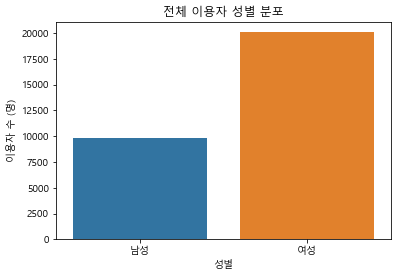

In [15]:
# 이용고객 성별 비율
gender = sns.countplot(x='ma_fem_dv', data = Demo1)
gender.set_title("전체 이용자 성별 분포")
gender.set_xlabel("성별")
gender.set_ylabel("이용자 수 (명)")
plt.rc('font', family="Malgun Gothic") 

- 남성보다 여성고객이 약 2배정도 더 많은 비율을 보입니다

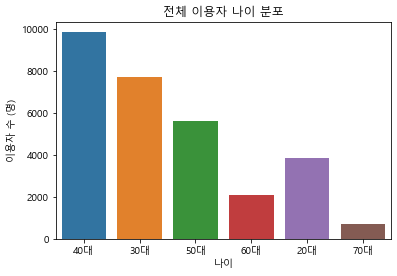

In [16]:
# 이용고객 나이대 비율
age = sns.countplot(x='ages', data = Demo1)
age.set_title("전체 이용자 나이 분포")
age.set_xlabel("나이")
age.set_ylabel("이용자 수 (명)")
plt.rc('font', family="Malgun Gothic") 

- 40대 이용 고객이 월등히 많고, 주된 고객 타겟층은 30~40대로 보입니다

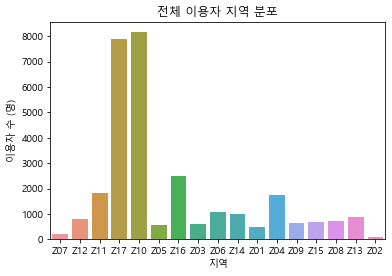

In [17]:
# 거주지 분류
locate = sns.countplot(x='zon_hlv', data = Demo1)
locate.set_title("전체 이용자 지역 분포")
locate.set_xlabel("지역")
locate.set_ylabel("이용자 수 (명)")
plt.rc('font', family="Malgun Gothic") 

- z17, z10 구역에 대부분의 고객이 분포함을 확인할 수 있습니다

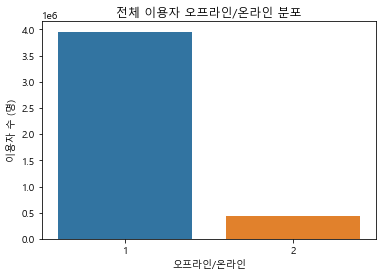

In [18]:
# 온라인, 오프라인 선호도 확인
chnl = sns.countplot(x='chnl_dv', data = purchase)
chnl.set_title("전체 이용자 오프라인/온라인 분포")
chnl.set_xlabel("오프라인/온라인")
chnl.set_ylabel("이용자 수 (명)")
plt.rc('font', family="Malgun Gothic") 

- 오프라인 이용자가 월등히 많습니다

# 1.2. 데이터를 연간 이용자 별 정리

In [5]:
purchase2 = purchase.sort_values(by='cust' ,ascending=False)

In [6]:
# datetime 열 만들기
from datetime import datetime

In [7]:
purchase3 = purchase2
purchase3['de_dt']= purchase3['de_dt'].astype('str')
purchase3['de_dt']=purchase3['de_dt'].apply(lambda _ : datetime.strptime(_,'%Y%m%d'))

- 이용자 별 구매 총 구매 금액

In [20]:
purchase4 = purchase3.groupby('cust').agg({'buy_am' : np.sum, 'buy_ct' : np.sum})
purchase4 = purchase4.rename(columns = {'buy_am' : 'buy' , 'buy_ct' : 'count'})

- 아웃라이어 제거

In [21]:
q3=purchase4['buy'].quantile(0.75)
q1=purchase4['buy'].quantile(0.25)
iqr= q3-q1
def is_outlier(purchase4):
    buy_am1 = purchase4['buy']
    if buy_am1 > q3 + 1.5 * iqr or buy_am1 < q1 - 1.5 * iqr:
        return True
    else:
        return False

purchase4['buy_1'] = purchase4.apply(is_outlier, axis = 1) 

# 이상치인 행은 제거하여 필터링
purchase_trim = purchase4.loc[purchase4['buy_1'] == False]

# 이상치여부를 나타내는 열 제거
del purchase_trim['buy_1']
purchase_trim = purchase_trim / 1000000

Text(0, 0.5, '이용자 수 (명)')

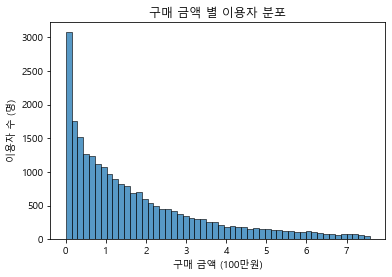

In [22]:
sum_money = sns.histplot(purchase_trim['buy'])
sum_money.set_title("구매 금액 별 이용자 분포")
sum_money.set_xlabel("구매 금액 (100만원)")
sum_money.set_ylabel("이용자 수 (명)")

- 총 구매액이 0~200 만원 사이 고객이 가장 많이 분포해 있다 
- 우리의 마케팅 목적은 0 에서 100 만원 소비 고객을 100 에서 200 만원 소비 고객으로 만드는것이 목표

# 1.3. 구매 금액 별 고객 그룹 나누기

- 0-100만원 소비 고객, 100-200만원 소비 고객 그룹으로 나누었다.

In [23]:
purchase5 = pd.merge(purchase3, purchase4, on = 'cust')
#0 ~ 100 , 100 ~ 200 소비자 나누기
am_100 = purchase5['buy'] < 1000000
am_200 = (purchase5['buy'] < 2000000) & (purchase5['buy'] > 1000000)
result_100 = purchase5[am_100]
result_200 = purchase5[am_200]

# 1.4. 그룹별 특징

# 1.4.1. 그룹별 이용 시간

In [51]:
import matplotlib.pyplot as plt

Text(0, 0.5, '이용자 수 (명)')

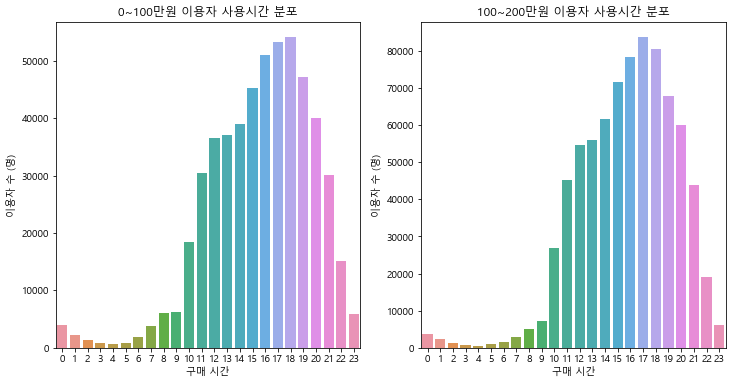

In [18]:
# 시간별 고객 분포 비교하기
result_100_hr = result_100.iloc[:,[7,9]]
result_200_hr = result_200.iloc[:,[7,9]]
fig, ax = plt.subplots(1, 2, figsize=(12,6))
hr_100 = sns.countplot(x='de_hr', data = result_100_hr, ax=ax[0])
hr_100.set_title("0~100만원 이용자 사용시간 분포")
hr_100.set_xlabel("구매 시간")
hr_100.set_ylabel("이용자 수 (명)")
hr_200 = sns.countplot(x='de_hr', data = result_200_hr, ax=ax[1])
hr_200.set_title("100~200만원 이용자 사용시간 분포")
hr_200.set_xlabel("구매 시간")
hr_200.set_ylabel("이용자 수 (명)")

# 1.4.2. 그룹별 선호 상품

In [19]:
# 물품 비교
result_100_pd = result_100.iloc[:,[5,9]]
result_200_pd = result_200.iloc[:,[5,9]]
result_100_pd = pd.merge(result_100_pd, product, on = 'pd_c')
result_200_pd = pd.merge(result_200_pd, product, on = 'pd_c')
pd_100 = result_100_pd.groupby('clac_hlv_nm').agg({'buy_ct': np.sum})
pd_200 = result_200_pd.groupby('clac_hlv_nm').agg({'buy_ct': np.sum})
# 가장 구매를 많이 한 7개 품목
pd_100_7 = pd_100.nlargest(7 , 'buy_ct').reset_index()
pd_200_7 = pd_200.nlargest(7 , 'buy_ct').reset_index()

Text(0, 0.5, '이용자 수 (명)')

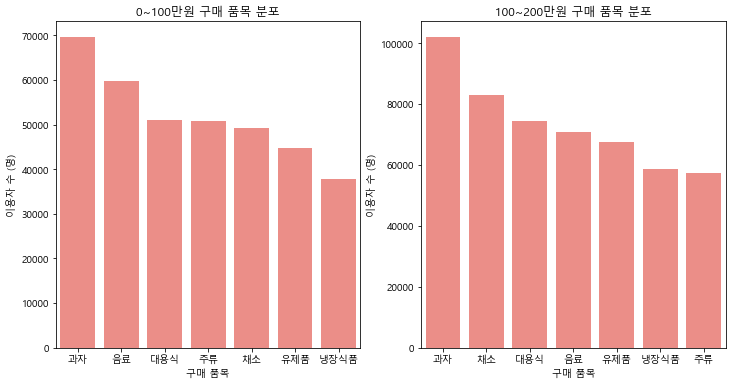

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
pro_100 = sns.barplot(x= "clac_hlv_nm" , y = "buy_ct" ,  data = pd_100_7, color = '#FC7F77', ax=ax[0])
pro_100.set_title("0~100만원 구매 품목 분포")
pro_100.set_xlabel("구매 품목")
pro_100.set_ylabel("이용자 수 (명)")
pro_200 = sns.barplot(x= "clac_hlv_nm" , y = "buy_ct" ,  data = pd_200_7, color = '#FC7F77', ax=ax[1])
pro_200.set_title("100~200만원 구매 품목 분포")
pro_200.set_xlabel("구매 품목")
pro_200.set_ylabel("이용자 수 (명)")

# 1.4.3. 그룹별 이용 지역

In [21]:
# 점포 비교
result_100_br = result_100.iloc[:,[4,9]]
result_200_br = result_200.iloc[:,[4,9]]
result_100_br = pd.merge(result_100_br, shop, on = 'br_c')
result_200_br = pd.merge(result_200_br, shop, on = 'br_c')
br_100 = result_100_br.groupby('zon_hlv').agg({'buy_ct': np.sum})
br_200 = result_200_br.groupby('zon_hlv').agg({'buy_ct': np.sum})
br_100_7 = br_100.nlargest(7 , 'buy_ct').reset_index()
br_200_7 = br_200.nlargest(7 , 'buy_ct').reset_index()

Text(0, 0.5, '이용자 수 (명)')

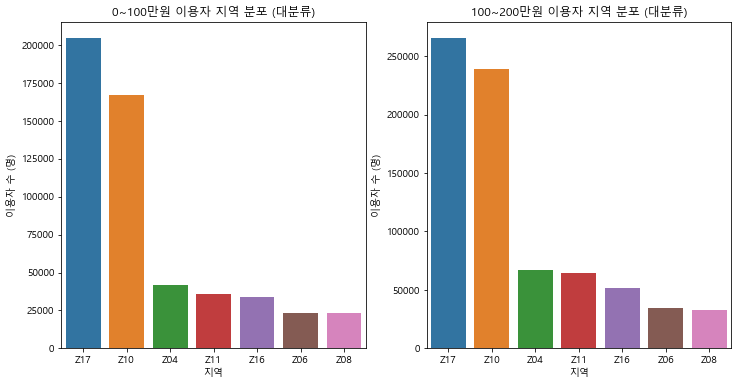

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
zone_100 = sns.barplot(x= "zon_hlv" , y = "buy_ct" ,  data = br_100_7, ax=ax[0])
zone_100.set_title("0~100만원 이용자 지역 분포 (대분류)")
zone_100.set_xlabel("지역")
zone_100.set_ylabel("이용자 수 (명)")
zone_200 = sns.barplot(x= "zon_hlv" , y = "buy_ct" ,  data = br_200_7, ax=ax[1])
zone_200.set_title("100~200만원 이용자 지역 분포 (대분류)")
zone_200.set_xlabel("지역")
zone_200.set_ylabel("이용자 수 (명)")

In [23]:
br_100_mc = result_100_br.groupby('zon_mcls').agg({'buy_ct': np.sum})
br_200_mc = result_200_br.groupby('zon_mcls').agg({'buy_ct': np.sum})
# 가장 많이 이용한 7 지역
br_100_7_mc = br_100_mc.nlargest(7 , 'buy_ct').reset_index()
br_200_7_mc = br_200_mc.nlargest(7 , 'buy_ct').reset_index()

Text(0, 0.5, '이용자 수 (명)')

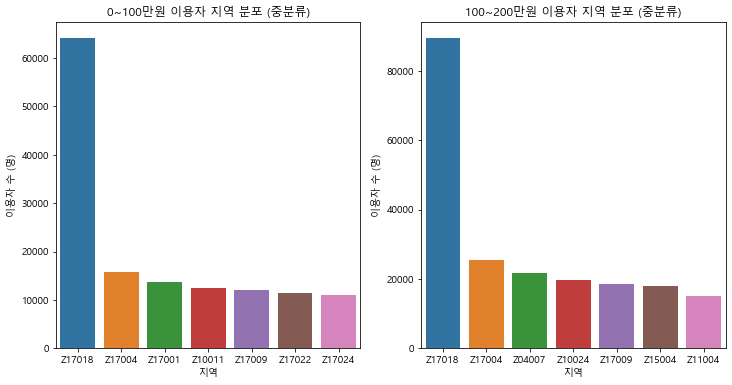

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
zone_re_100 = sns.barplot(x= "zon_mcls" , y = "buy_ct" ,  data = br_100_7_mc, ax=ax[0])
zone_re_100.set_title("0~100만원 이용자 지역 분포 (중분류)")
zone_re_100.set_xlabel("지역")
zone_re_100.set_ylabel("이용자 수 (명)")
zone_re_200 = sns.barplot(x= "zon_mcls" , y = "buy_ct" ,  data = br_200_7_mc, ax=ax[1])
zone_re_200.set_title("100~200만원 이용자 지역 분포 (중분류)")
zone_re_200.set_xlabel("지역")
zone_re_200.set_ylabel("이용자 수 (명)")

# 1.4.4. 그룹별 선호 제휴사

In [25]:
Demo_1 = Demo.sort_values(by='cust',ascending = True)
result_1 = pd.merge(Demo_1, purchase4, on = 'cust')
Lpay2 = Lpay.iloc[:,[0,2]]
result_2 = pd.merge(result_1, Lpay2, on = 'cust')
result_2

,cust,ma_fem_dv,ages,zon_hlv,buy,count,buy_1,cop_c
0,M000136117,여성,30대,Z11,27373630.0,114,True,D01
1,M000136117,여성,30대,Z11,27373630.0,114,True,A06
2,M000136117,여성,30대,Z11,27373630.0,114,True,A06
3,M000136117,여성,30대,Z11,27373630.0,114,True,A01
4,M000419293,여성,40대,Z17,1833500.0,71,False,D01
...,...,...,...,...,...,...,...,...
350050,M999962961,여성,50대,Z17,11847248.0,416,True,L00
350051,M999962961,여성,50대,Z17,11847248.0,416,True,A01
350052,M999962961,여성,50대,Z17,11847248.0,416,True,C02
350053,M999962961,여성,50대,Z17,11847248.0,416,True,A06


In [26]:
am_200 = (result_2['buy'] < 2000000) & (result_2['buy'] > 1000000)
am_100 = (result_2['buy'] < 1000000)
result_100 = result_2[am_100]
result_200 = result_2[am_200]

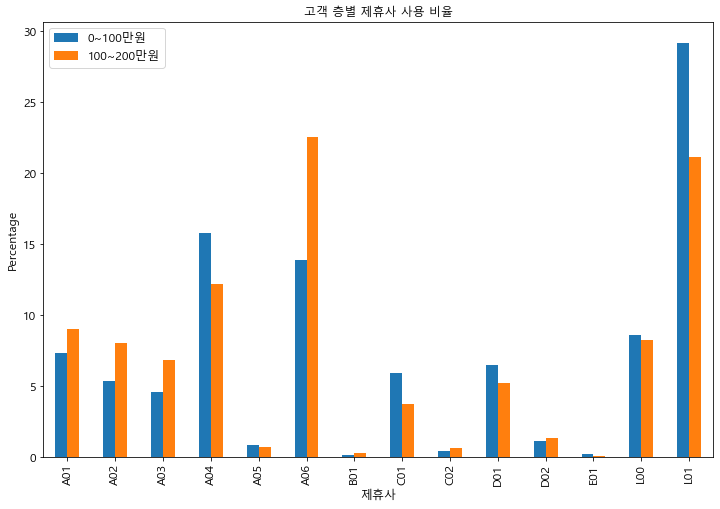

In [27]:
# 제휴사 순서대로 정렬
result_100_asc = result_100.sort_values(by='cop_c', ascending=True)
result_200_asc = result_200.sort_values(by='cop_c', ascending=True)
# normalize
result_100_nor = result_100_asc['cop_c'].value_counts(normalize=True, sort=False)
result_200_nor = result_200_asc['cop_c'].value_counts(normalize=True, sort=False)
result_nor = pd.concat([result_100_nor,result_200_nor], axis=1,ignore_index=False)
result_nor = result_nor * 100
result_nor.columns = ['100', '200']
# 차트 종류, 제목, 차트 크기, 범례, 폰트 크기 설정
af_end = result_nor.plot(kind='bar', title='고객 층별 제휴사 사용 비율', figsize=(12, 8), legend=True, fontsize=12)
af_end.set_xlabel('제휴사', fontsize=12)          # x축 정보 표시
af_end.set_ylabel('Percentage', fontsize=12)     # y축 정보 표시
af_end.legend(['0~100만원', '100~200만원'], fontsize=12)    # 범례 지정

# 고객 다시 정리

In [24]:
pur = pd.merge(purchase2, Demo, on = 'cust')

In [25]:
pur = pd.merge(pur, product, on = 'pd_c')

In [26]:
pur = pd.merge(pur, purchase4, on = 'cust')

In [27]:
pur = pur.drop(columns = 'buy_1')

In [28]:
m_100 = pur['buy'] < 1000000
m_200 = (pur['buy'] < 2000000) & (pur['buy'] > 1000000)

In [29]:
pur_100 = pur[m_100]
pur_200 = pur[m_200]

# 온라인/오프라인 이용 빈도수

In [36]:
pur_100_off = pur_100[pur_100.chnl_dv == 1]
pur_100_on = pur_100[pur_100.chnl_dv == 2]
pur_200_off = pur_200[pur_200.chnl_dv == 1]
pur_200_on = pur_200[pur_200.chnl_dv == 2]

In [37]:
pur_100_off_10 = pd.DataFrame(pur_100_off.value_counts('clac_hlv_nm').head(10))
pur_200_off_10 = pd.DataFrame(pur_200_off.value_counts('clac_hlv_nm').head(10))
pur_100_on_10 = pd.DataFrame(pur_100_on.value_counts('clac_hlv_nm').head(10))
pur_200_on_10 = pd.DataFrame(pur_200_on.value_counts('clac_hlv_nm').head(10))

Text(0, 0.5, '이용자 수 (명)')

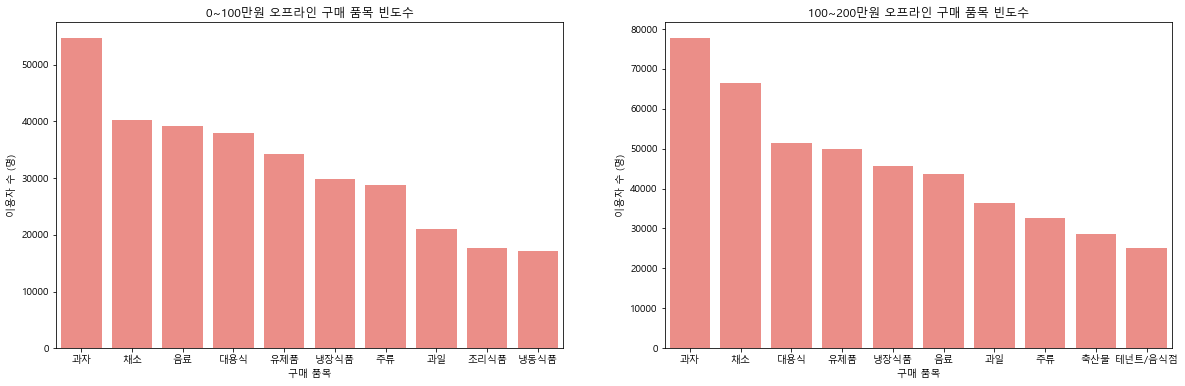

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20,6))
pro_100_off = sns.barplot(x= pur_100_off_10.index , y = 0 ,  data = pur_100_off_10, color = '#FC7F77', ax=ax[0])
pro_100_off.set_title("0~100만원 오프라인 구매 품목 빈도수")
pro_100_off.set_xlabel("구매 품목")
pro_100_off.set_ylabel("이용자 수 (명)")
pro_200_off = sns.barplot(x= pur_200_off_10.index , y = 0 ,  data = pur_200_off_10, color = '#FC7F77', ax=ax[1])
pro_200_off.set_title("100~200만원 오프라인 구매 품목 빈도수")
pro_200_off.set_xlabel("구매 품목")
pro_200_off.set_ylabel("이용자 수 (명)")

# 0 ~ 100만원 소비자에게 랜덤 포레스트를 이용한 소비에 영향을 끼치는 변수 찾기

In [41]:
result_100 = pur_100.iloc[:,[2,3,6,7,8,10,11,12]]

In [42]:
result_100['year'] = result_100['de_dt'].dt.year
result_100['month'] = result_100['de_dt'].dt.month
result_100['day'] = result_100['de_dt'].dt.day

C:\Users\kinsh\AppData\Local\Temp/ipykernel_15436/1120709812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_100['year'] = result_100['de_dt'].dt.year
C:\Users\kinsh\AppData\Local\Temp/ipykernel_15436/1120709812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_100['month'] = result_100['de_dt'].dt.month
C:\Users\kinsh\AppData\Local\Temp/ipykernel_15436/1120709812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [43]:
# 모든 데이터가 2021년이라 년도와 분리전 날짜 제거
result_100 = result_100.iloc[:,[0,1,3,4,5,6,7,9,10]]

In [44]:
result_100.columns

Index(['chnl_dv', 'cop_c', 'de_hr', 'buy_am', 'ma_fem_dv', 'ages', 'zon_hlv',
       'month', 'day'],
      dtype='object')

In [45]:
# 제휴사 one-hot-encoding
result_100['cop_c'].replace({
    'A01' : 1, 'A02' : 2, 'A03' : 3, 'A04' : 4, 'A05' : 5, 'A06' : 6}, inplace = True)

In [46]:
# 나이대 one_hot_encoding
result_100['ages'].replace({
    '20대': 2, '30대': 3, '40대': 4, '50대' : 5 , '60대' : 6, '70대' : 7}, inplace = True)

In [47]:
# 성별 one_hot_encoding
result_100['ma_fem_dv'].replace({'남성':0, '여성':1}, inplace=True)

In [48]:
result_100['zon_hlv'].unique()

array(['Z10', 'Z17', 'Z16', 'Z04', 'Z08', 'Z01', 'Z03', 'Z06', 'Z09',
       'Z15', 'Z05', 'Z11', 'Z14', 'Z13', 'Z07', 'Z02', 'Z12'],
      dtype=object)

In [49]:
# 지역 one_hot_encoding
result_100['zon_hlv'].replace({
    'Z01': 1, 'Z02': 2, 'Z03' : 3, 'Z04' : 4, 'Z05' : 5,'Z06' : 6,'Z07' : 7,'Z08' : 8,'Z09' : 9,'Z10' : 10,'Z11' : 11,'Z12' : 12,'Z13' : 13, 'Z14' : 14, 'Z15' : 15, 'Z16' : 16, 'Z17' : 17}, inplace=True)

In [50]:
result_100

,chnl_dv,cop_c,de_hr,buy_am,ma_fem_dv,ages,zon_hlv,month,day
422,1,1,14,45000.0,1,4,10,11,25
423,1,1,15,39000.0,1,4,10,5,11
424,1,1,17,171000.0,1,4,10,12,16
425,1,1,12,10000.0,1,4,10,3,20
426,1,1,12,100.0,1,4,10,3,20
...,...,...,...,...,...,...,...,...,...
4381736,2,6,15,20700.0,1,3,10,1,14
4381739,1,5,14,47000.0,1,6,6,12,5
4381740,2,6,17,8300.0,1,2,16,4,21
4381741,2,6,14,202000.0,1,4,10,5,10


# 훈련데이터와 테스트 데이터 나누기

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [52]:
X_train, X_test, y_train, y_test = train_test_split(result_100[['chnl_dv', 'cop_c', 'de_hr','ma_fem_dv','ages','zon_hlv','month','day']],\
                                                    result_100['buy_am'],test_size = 0.2, random_state =42)

In [53]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((425336, 8), (106335, 8), (425336,), (106335,))

# 랜덤 포레스트를 통한 가격 예측

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
print(X_train)
print(X_test)

[[-0.25314988 -1.64255205  0.08611877 ...  1.19914649 -0.37428482
   0.60745128]
 [-0.25314988 -1.64255205 -1.14828371 ...  1.19914649  0.50653055
  -0.18230324]
 [-0.25314988  0.36795036  0.82676025 ... -0.31690163 -0.66788995
   0.49462921]
 ...
 [-0.25314988  1.37320156  1.07364075 ...  1.19914649  0.50653055
  -0.06948116]
 [-0.25314988 -0.63730085  1.56740174 ...  1.19914649  1.68095106
  -0.74641361]
 [-0.25314988 -0.63730085  1.07364075 ...  1.19914649  0.80013568
   0.49462921]]
[[-0.25424046 -1.63688652 -0.6506665  ...  0.54660361  1.09441345
  -1.41893229]
 [-0.25424046  1.37301044 -0.15735003 ...  0.33054628  1.38744919
  -1.19362288]
 [-0.25424046  1.37301044 -0.40400826 ... -0.31762571  1.09441345
   1.17212594]
 ...
 [-0.25424046  0.36971145  0.08930821 ... -0.31762571 -1.24987245
   0.04557889]
 [-0.25424046 -0.63358753 -0.40400826 ... -1.18185504 -0.66380097
  -1.19362288]
 [-0.25424046  0.36971145  0.33596645 ...  1.19477561 -0.95683671
   1.62274476]]


In [56]:
from sklearn.ensemble import RandomForestRegressor 

rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(rf.score(X_train,y_train))

0.7586571138730162


# 변수 중요도

In [61]:
r_100 = result_100.columns.to_list()
r_100.pop(3)

'buy_am'

In [62]:
r_100

['chnl_dv', 'cop_c', 'de_hr', 'ma_fem_dv', 'ages', 'zon_hlv', 'month', 'day']

Feature importances:
[0.008 0.22  0.183 0.04  0.096 0.081 0.139 0.232]
chnl_dv : 0.008
cop_c : 0.220
de_hr : 0.183
buy_am : 0.040
ma_fem_dv : 0.096
ages : 0.081
zon_hlv : 0.139
month : 0.232


<AxesSubplot:>

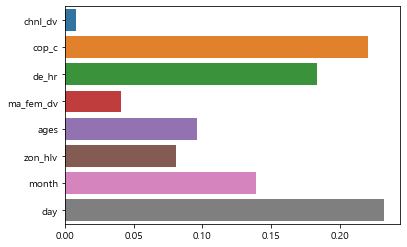

In [63]:
import seaborn as sns
import numpy as np
%matplotlib inline

# feature importance 추출 
print("Feature importances:\n{0}".format(np.round(rf.feature_importances_, 3)))

# feature별 importance 매핑
for name, value in zip(result_100.columns , rf.feature_importances_):
    print('{0} : {1:.3f}'.format(name, value))

# feature importance를 column 별로 시각화 하기 
sns.barplot(x=rf.feature_importances_ , y=r_100)

- 제휴사, 날짜, 시간대가 구매 액수의 가장 영향을 많이 끼친다 판단

# ------

# 0~100만원 고객의 매출 상승경향 예측

In [30]:
Day_100 = pur_100.iloc[:,[0,6,7,8]]

In [31]:
Day_100

,cust,de_dt,de_hr,buy_am
422,M984897819,2021-11-25,14,45000.0
423,M984897819,2021-05-11,15,39000.0
424,M984897819,2021-12-16,17,171000.0
425,M984897819,2021-03-20,12,10000.0
426,M984897819,2021-03-20,12,100.0
...,...,...,...,...
4381736,M069201464,2021-01-14,15,20700.0
4381739,M321104982,2021-12-05,14,47000.0
4381740,M747273068,2021-04-21,17,8300.0
4381741,M296048730,2021-05-10,14,202000.0


In [32]:
Day_100_hr = Day_100.groupby('de_hr').agg({'buy_am': np.sum})
Day_100_de = Day_100.groupby('de_dt').agg({'buy_am': np.sum})

In [33]:
Day_100_de

,buy_am
de_dt,
2021-01-01,12290443.0
2021-01-02,17787064.0
2021-01-03,13391124.0
2021-01-04,13406966.0
2021-01-05,10956685.0
...,...
2021-12-27,7672829.0
2021-12-28,10686842.0
2021-12-29,9259687.0


In [34]:
Day_100_de.reset_index( inplace=True )

In [35]:
Day_100_de

,de_dt,buy_am
0,2021-01-01,12290443.0
1,2021-01-02,17787064.0
2,2021-01-03,13391124.0
3,2021-01-04,13406966.0
4,2021-01-05,10956685.0
...,...,...
360,2021-12-27,7672829.0
361,2021-12-28,10686842.0
362,2021-12-29,9259687.0
363,2021-12-30,13086612.0


# 향후 5일만을 예측하기 5일로 나눈다

In [43]:
Day_train = Day_100_de[:360]

In [44]:
Day_test = Day_100_de[360:]

# Arima model

In [45]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# (AR = 2, 차분 =1, MA=2) 파라미터로 ARIMA 모델을 학습한다.
model = ARIMA(Day_train.buy_am.values, order = (2,1,2))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

C:\Users\kinsh\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  359
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5902.618
Method:                       css-mle   S.D. of innovations        3333262.714
Date:                Mon, 08 Aug 2022   AIC                          11817.235
Time:                        14:37:30   BIC                          11840.535
Sample:                             1   HQIC                         11826.501
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8603.3982   1.59e+04     -0.543      0.587   -3.97e+04    2.25e+04
ar.L1.D.y      0.8999      0.102      8.781      0.000       0.699       1.101
ar.L2.D.y     -0.4169      0.069     -6.052      0.0

- 상수항을 제외하고는 유의수준 0.05 이하

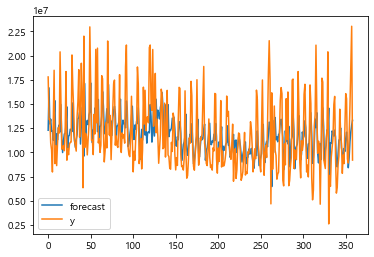

In [46]:
fig = model_fit.plot_predict()

<AxesSubplot:title={'center':'실제값과 예측값의 잔차'}>

C:\Users\kinsh\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kinsh\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


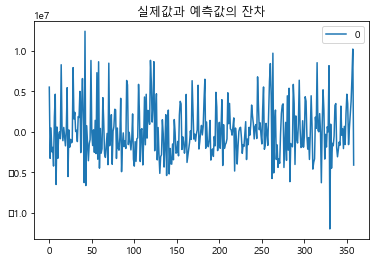

In [47]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title = "실제값과 예측값의 잔차")

In [48]:
forecast_data = model_fit.forecast(steps=5) 

In [49]:
# 마지막 5일의 예측 데이터 
pred_arima_y = forecast_data[0].tolist()

# 실제 5일의 데이터 
test_y = Day_test.buy_am.values

# 마지막 5일의 예측 데이터 최소값
pred_y_lower = []
# 마지막 5일의 예측 데이터 최대값
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

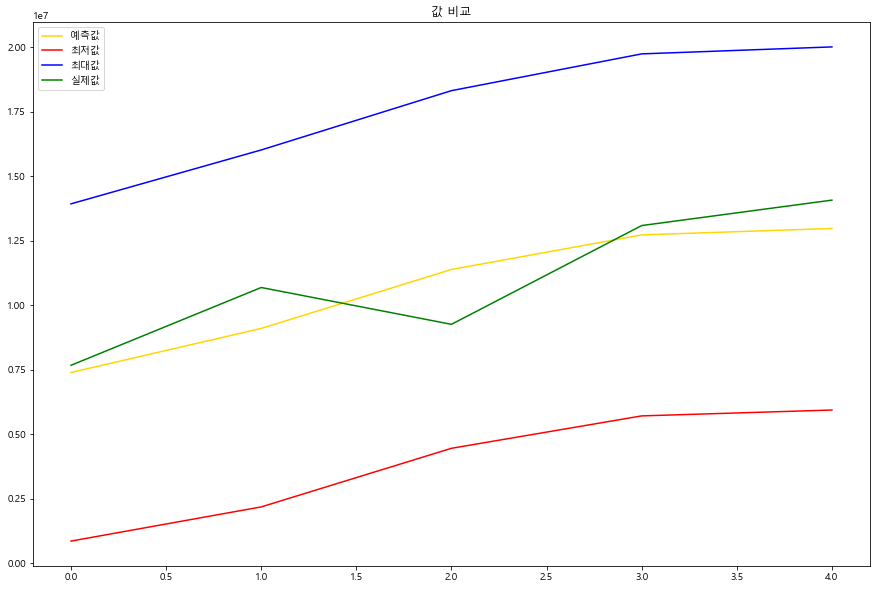

In [52]:
plt.figure(figsize=(15, 10))

# 모델이 예측한 가격 그래프
plt.plot(pred_arima_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

plt.legend(['예측값', '최저값','최대값','실제값'])
plt.title("값 비교")
plt.show()